In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from scipy.io import savemat, loadmat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics, losses
from tensorflow.keras import backend as K

You can use the following keras tutorial for sequential models to implement and train your network in this problem.

https://keras.io/getting-started/sequential-model-guide/

# Part 1

In order to relate surface flow velocity of a river to its depth, we construct a multi-layer neural network that
consists of a series of Dense layers with batch normalization and ’tanh’ activation function. For the final layer, we used Identity function as the activation function because it's a regression problem and we don't want to limit the output to a certain range.

Since it's a regression problem, we use mean square error as the loss function.

In [32]:
def generate_model(input_dim, output_dim, n_layer, n_hidden,
                   optimizer_meth, act_fcn, learning_rate = 0.001, reg=0.01):
    """
    input_dim:           the size of input vector
    output_dim:          the size of output vector
    n_layer:             number of hidden layers in the network
    n_hidden:            a list of number of hidden units in each hidden layer. 
                         for example, for n_hidden=3, this can be [200, 100, 45]
    optimizer_meth:      the optimization method used for training
    act_fcn              the type of activation function in the hidden layers
    learning_rate        Learning rate used in the training phase
    reg                  L2 regularization coefficient
    """
    # we build the first layer outside of the for loop:
    model = Sequential()  
    model.add(Dense(units=n_hidden[0],input_dim=input_dim,
                    kernel_regularizer = regularizers.l2(reg)))
    model.add(BatchNormalization())
    model.add(Activation(act_fcn))
    #### ToDo build your model here and compile it.
    """ hint: Keep the parameters for the hidden layers the same, and use for loop to add the layers to the 
              network. Add the last layer (output layer) outside the for loop since it has a different
              activation function. 
        
    """
    # loop to add the hidden layers:
    for i in range(1, n_layer):
        model.add(Dense(units=n_hidden[i],input_dim=n_hidden[i-1], kernel_regularizer = regularizers.l2(reg)))
        model.add(BatchNormalization())
        model.add(Activation(act_fcn))
    
    #final layer:
    model.add(Dense(units=output_dim, activation='linear',kernel_regularizer = regularizers.l2(reg)))
    
    #compiling the model:
    model.compile(loss='mean_squared_error', optimizer=optimizer_meth, metrics=['mse'])  
    
    return model

In [33]:
def train(model, x_train, y_train, batch_s, n_epochs, verbose=1, validation_split=.2):
    """
    model:       the DNN model (the output of generate_model)
    x_train:     input of the network
    y_train:     output of the network
    batch_size:  batch size parameter
    epochs:      number of epochs used to train the network
    validation_split:  validation/train split ration
    """
    
    #### ToDo:  use the training data and train your model. 
    #### hint: Plot the loss function for the training and validation set to observe your network performance.
    
    #fitting the data to the DNN:
    history = model.fit(x_train, y_train, batch_size = batch_s, epochs = n_epochs, verbose=verbose, validation_split=validation_split,shuffle=False)
    #plot train loss:
    plt.plot(history.history['loss'],'b')
    #plot validation loss:
    plt.plot(history.history['val_loss'],'r')
    return history.history['val_mse']

In [34]:
def hyp_tuning(learning_rate = [1e-4,1e-3,1e-2,1e-1], regularization = [1e-4,1e-3,1e-2,1e-1],n_layer=1,hidden_nodes=50):
    ### ToDo: find the optimal combination of learning rate and regularization coefficient.
    # add more inputs to the function if necessary
    
    # initialize number of epochs and batch size:
    epochs = 10
    batch_size = 256
    losses = np.zeros((len(learning_rate), len(regularization)))
    mses = np.zeros((len(learning_rate), len(regularization)))
    
    # use a for loop to train over different parameters:
    for lr in range(len(learning_rate)):
        for reg in range(len(regularization)):

            optimizer_meth = Adam(lr=learning_rate[lr], beta_1=0.9, beta_2=0.999, decay=2e-6, amsgrad=False)

            model = generate_model(X_train.shape[1], Y_train.shape[1], n_layer, hidden_nodes, optimizer_meth, 'tanh',
                                   learning_rate[lr], regularization[reg])
            mses[lr,reg] = train(model, X_train, Y_train, batch_size, epochs)[-1]

    # determine which hyperparameters are optimal:
    [lr_ind, reg_ind] = np.unravel_index(mses.argmin(), mses.shape)
    
    return learning_rate[lr_ind], regularization[reg_ind]

In [35]:
# Don't change this block. It's for post-processing and plotting the results
def post_process_low_rank(data, U):
    nx = [501, 41]
    n_edge = 11
    a = np.zeros((nx[1], nx[0]))
    for i in range(data.shape[0]):
        a[:, i:i+n_edge] += np.dot(U, data[i, :]).reshape(nx[1], -1)
    for i in range(n_edge):
        a[:, i] = a[:, i]/(i+1)
        a[:, nx[0]-i-1] = a[:, nx[0]-i-1]/(i+1)

    a[:, n_edge: nx[0]-n_edge] = a[:, n_edge: nx[0]-n_edge]/n_edge
    return a

def post_process(data):
    nx = [501, 41]
    n_edge = 11
    a = np.zeros((nx[1], nx[0]))
    for i in range(data.shape[0]):
        a[:, i:i+n_edge] += data[i, :].reshape(nx[1], -1)
    for i in range(n_edge):
        a[:, i] = a[:, i]/(i+1)
        a[:, nx[0]-i-1] = a[:, nx[0]-i-1]/(i+1)

    a[:, n_edge: nx[0]-n_edge] = a[:, n_edge: nx[0]-n_edge]/n_edge
    return a

def plt_im_tri(depth, fig_name, show_file=True, vmin_=21, vmax_=29,label_z='Elevation [m]'):
    mesh = loadmat("mesh.mat")
    triangles = mesh['triangles']
    meshnode = mesh['meshnode']
    matplotlib.rcParams.update({'font.size': 16})

    offsetx = 220793.
    offsety = 364110.
    fig_index = 1
    plt.figure(fig_index, figsize=(10., 10.), dpi=100)
    fig_index += 1
    ax = plt.gca()
    im = plt.tripcolor(meshnode[:, 0]*0.3010-offsetx, meshnode[:, 1]*0.3010-offsety,
                       triangles, depth*0.301, cmap=plt.get_cmap('jet'), vmin=vmin_, vmax=vmax_, label='_nolegend_')
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Northing [m]")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis([0., 1000., 0., 530.])
    plt.xticks(np.arange(0., 1000.+10., 200.0))
    plt.yticks(np.arange(0., 530.+10., 200.0))
    cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
    cbar.set_label(label_z)
    plt.rcParams['axes.axisbelow'] = True
    plt.rc('axes', axisbelow=True)
    plt.grid()
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.savefig(fig_name)
    if show_file:
        plt.show()

def plot_inverse(model, mean_V=None, std_V=None, mean_Z=None, std_Z=None):
    data_red_river = loadmat('P2_test.mat')
    V = data_red_river['X']
    Z = data_red_river['Y']
    Uz = data_red_river['U']
    V_P = (V-mean_V)/std_V
    pred = model.predict(V_P)
    Z_P = pred*std_Z+mean_Z
    river_prof = post_process_low_rank(Z_P, Uz)
    plt_im_tri(river_prof.ravel(), 'predicted_river.jpg', False,21,29,label_z='Elevation [m]')
    
def plot_forward_low_rank(model, mean_Z=None, std_Z=None, mean_V=None, std_V=None, U_l=None):
    data_red_river = loadmat('P2_test.mat')
    V = data_red_river['X']
    Z = data_red_river['Y']
    Uz = data_red_river['U']
    Z_P = (Z-mean_Z)/std_Z
    pred = model.predict(Z_P)
    V_P = pred*std_V+mean_V
    velocity_prof = post_process_low_rank(V_P, U_l)
    plt_im_tri(velocity_prof.ravel(), 'predicted_velocity.jpg', False,-0.5,1,label_z='Velocity [m/s]')
    
def plot_forward(model, mean_Z=None, std_Z=None, mean_V=None, std_V=None):
    data_red_river = loadmat('P2_test.mat')
    V = data_red_river['X']
    Z = data_red_river['Y']
    Uz = data_red_river['U']
    Z_P = (Z-mean_Z)/std_Z
    pred = model.predict(Z_P)
    V_P = pred*std_V+mean_V
    velocity_prof = post_process(V_P)
    plt_im_tri(velocity_prof.ravel(), 'predicted_velocity.jpg', False,-0.5,1,label_z='Velocity [m/s]')

# Part 2-4


Using a 20% validation split, we train the network for 500-1000 epochs. 

In [36]:
# Load data and set up network input/output:
data = loadmat('P2_train.mat')
V = data['X']
Z = data['Y']

# Normalize input and output of the network:
std_Z = np.std(Z, 0)
std_Z[std_Z==0] = 1
mean_Z = np.mean(Z,0)
std_V = np.std(V,0)
std_V[std_V==0] = 1
mean_V = np.mean(V,0)
X_train = (Z - mean_Z)/std_Z #network input
Y_train = (V - mean_V)/std_V #network ouput

In [13]:
# ToDo: complete hyp_tuning() function and find the optimal hyper parameters

lr, reg = hyp_tuning([1e-4, 1e-3, 1e-2, 1e-1],[1e-4, 1e-3, 1e-2, 1e-1],6,[800, 700, 700, 600, 600, 500])

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 4s 229us/step - loss: 0.9912 - mse: 0.6134 - val_loss: 0.7541 - val_mse: 0.3782
Epoch 2/10
16000/16000 [==============================] - 3s 168us/step - loss: 0.7055 - mse: 0.3319 - val_loss: 0.6902 - val_mse: 0.3190
Epoch 3/10
16000/16000 [==============================] - 3s 169us/step - loss: 0.6216 - mse: 0.2528 - val_loss: 0.6125 - val_mse: 0.2461
Epoch 4/10
16000/16000 [==============================] - 3s 172us/step - loss: 0.5605 - mse: 0.1964 - val_loss: 0.5605 - val_mse: 0.1988
Epoch 5/10
16000/16000 [==============================] - 3s 175us/step - loss: 0.5208 - mse: 0.1613 - val_loss: 0.5298 - val_mse: 0.1727
Epoch 6/10
16000/16000 [==============================] - 3s 168us/step - loss: 0.4932 - mse: 0.1382 - val_loss: 0.5082 - val_mse: 0.1557
Epoch 7/10
16000/16000 [==============================] - 3s 170us/step - loss: 0.4725 - mse: 0.1222 - val_loss: 0.4921 - v

Epoch 8/10
16000/16000 [==============================] - 3s 176us/step - loss: 0.2568 - mse: 0.1511 - val_loss: 0.4024 - val_mse: 0.3028
Epoch 9/10
16000/16000 [==============================] - 3s 182us/step - loss: 0.2379 - mse: 0.1419 - val_loss: 0.3705 - val_mse: 0.2807
Epoch 10/10
16000/16000 [==============================] - 3s 190us/step - loss: 0.2184 - mse: 0.1324 - val_loss: 0.4762 - val_mse: 0.3950
Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 4s 256us/step - loss: 13.1429 - mse: 0.4310 - val_loss: 2.4729 - val_mse: 0.9833
Epoch 2/10
16000/16000 [==============================] - 3s 178us/step - loss: 0.8921 - mse: 0.3925 - val_loss: 1.0036 - val_mse: 0.8356
Epoch 3/10
16000/16000 [==============================] - 3s 177us/step - loss: 0.5479 - mse: 0.4091 - val_loss: 1.0951 - val_mse: 0.9758
Epoch 4/10
16000/16000 [==============================] - 3s 173us/step - loss: 0.5095 - mse: 0.4001 - val_loss: 0.6284 -

In [43]:
# Output the optimal hyperparameters
print(lr)
print(reg)

0.0001
0.001


In [37]:
"""
ToDo:  
Set up the input parameters for the train function then use the normalized training data to train your network.

hint:
Try to use large number of hidden units for the first few layers.
Use more than four hidden layer in your network structure

Note: This section of the problem can be challenging if you haven't had prior experience in deep learning.
      You need to try different values for the number of layers and number of hidden units, learning rate,
      optimization method, ...
"""

# Set up the parameter of the network and generate the network:
input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]
n_layer = 8
n_hidden = [800, 800, 700, 700, 600, 600, 500, 500]
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, decay=2e-6, amsgrad=False)

optimizer_meth = adam
act_fcn = 'tanh'
model = generate_model(input_dim, output_dim, n_layer, n_hidden,
                       optimizer_meth, act_fcn, learning_rate = 1e-4, reg=1e-3)

# Check the dimensions of input and output:
print(X_train.shape)
print(Y_train.shape)

(20000, 41)
(20000, 451)


Train on 16000 samples, validate on 4000 samples
Epoch 1/1000
16000/16000 [==============================] - 9s 590us/step - loss: 5.5162 - mse: 0.5952 - val_loss: 5.0765 - val_mse: 0.3877
Epoch 2/1000
16000/16000 [==============================] - 6s 395us/step - loss: 4.7619 - mse: 0.3060 - val_loss: 4.5340 - val_mse: 0.3139
Epoch 3/1000
16000/16000 [==============================] - 6s 372us/step - loss: 4.2378 - mse: 0.2226 - val_loss: 4.0464 - val_mse: 0.2377
Epoch 4/1000
16000/16000 [==============================] - 6s 378us/step - loss: 3.8010 - mse: 0.1722 - val_loss: 3.6414 - val_mse: 0.1937
Epoch 5/1000
16000/16000 [==============================] - 6s 385us/step - loss: 3.4276 - mse: 0.1395 - val_loss: 3.2918 - val_mse: 0.1648
Epoch 6/1000
16000/16000 [==============================] - 6s 376us/step - loss: 3.1029 - mse: 0.1181 - val_loss: 2.9885 - val_mse: 0.1474
Epoch 7/1000
16000/16000 [==============================] - 6s 392us/step - loss: 2.8182 - mse: 0.1041 - val_lo

Epoch 59/1000
16000/16000 [==============================] - 6s 393us/step - loss: 0.2691 - mse: 0.0457 - val_loss: 0.3034 - val_mse: 0.0835
Epoch 60/1000
16000/16000 [==============================] - 6s 397us/step - loss: 0.2604 - mse: 0.0438 - val_loss: 0.2960 - val_mse: 0.0829
Epoch 61/1000
16000/16000 [==============================] - 7s 414us/step - loss: 0.2536 - mse: 0.0436 - val_loss: 0.2931 - val_mse: 0.0864
Epoch 62/1000
16000/16000 [==============================] - 6s 401us/step - loss: 0.2484 - mse: 0.0448 - val_loss: 0.2773 - val_mse: 0.0768
Epoch 63/1000
16000/16000 [==============================] - 6s 398us/step - loss: 0.2424 - mse: 0.0449 - val_loss: 0.2730 - val_mse: 0.0784
Epoch 64/1000
16000/16000 [==============================] - 7s 417us/step - loss: 0.2351 - mse: 0.0434 - val_loss: 0.2678 - val_mse: 0.0789
Epoch 65/1000
16000/16000 [==============================] - 7s 416us/step - loss: 0.2273 - mse: 0.0412 - val_loss: 0.2623 - val_mse: 0.0791
Epoch 66/1000

Epoch 117/1000
16000/16000 [==============================] - 6s 376us/step - loss: 0.0963 - mse: 0.0330 - val_loss: 0.1425 - val_mse: 0.0797
Epoch 118/1000
16000/16000 [==============================] - 6s 359us/step - loss: 0.0940 - mse: 0.0316 - val_loss: 0.1277 - val_mse: 0.0659
Epoch 119/1000
16000/16000 [==============================] - 6s 344us/step - loss: 0.0920 - mse: 0.0306 - val_loss: 0.1231 - val_mse: 0.0623
Epoch 120/1000
16000/16000 [==============================] - 6s 357us/step - loss: 0.0925 - mse: 0.0320 - val_loss: 0.1275 - val_mse: 0.0675
Epoch 121/1000
16000/16000 [==============================] - 6s 390us/step - loss: 0.0930 - mse: 0.0334 - val_loss: 0.1273 - val_mse: 0.0681
Epoch 122/1000
16000/16000 [==============================] - 7s 425us/step - loss: 0.0923 - mse: 0.0335 - val_loss: 0.1279 - val_mse: 0.0695
Epoch 123/1000
16000/16000 [==============================] - 7s 408us/step - loss: 0.0923 - mse: 0.0340 - val_loss: 0.1312 - val_mse: 0.0733
Epoch 

Epoch 175/1000
16000/16000 [==============================] - 6s 376us/step - loss: 0.0718 - mse: 0.0303 - val_loss: 0.1074 - val_mse: 0.0660
Epoch 176/1000
16000/16000 [==============================] - 6s 374us/step - loss: 0.0744 - mse: 0.0329 - val_loss: 0.1062 - val_mse: 0.0647
Epoch 177/1000
16000/16000 [==============================] - 6s 351us/step - loss: 0.0726 - mse: 0.0312 - val_loss: 0.1071 - val_mse: 0.0658
Epoch 178/1000
16000/16000 [==============================] - 5s 332us/step - loss: 0.0709 - mse: 0.0297 - val_loss: 0.1059 - val_mse: 0.0648
Epoch 179/1000
16000/16000 [==============================] - 6s 347us/step - loss: 0.0701 - mse: 0.0291 - val_loss: 0.1096 - val_mse: 0.0688
Epoch 180/1000
16000/16000 [==============================] - 6s 347us/step - loss: 0.0705 - mse: 0.0298 - val_loss: 0.1274 - val_mse: 0.0868
Epoch 181/1000
16000/16000 [==============================] - 6s 357us/step - loss: 0.0725 - mse: 0.0318 - val_loss: 0.1103 - val_mse: 0.0697
Epoch 

Epoch 233/1000
16000/16000 [==============================] - 5s 332us/step - loss: 0.0797 - mse: 0.0427 - val_loss: 0.1133 - val_mse: 0.0757
Epoch 234/1000
16000/16000 [==============================] - 5s 331us/step - loss: 0.0745 - mse: 0.0367 - val_loss: 0.0989 - val_mse: 0.0610
Epoch 235/1000
16000/16000 [==============================] - 5s 333us/step - loss: 0.0655 - mse: 0.0278 - val_loss: 0.0945 - val_mse: 0.0571
Epoch 236/1000
16000/16000 [==============================] - 5s 333us/step - loss: 0.0639 - mse: 0.0266 - val_loss: 0.0934 - val_mse: 0.0563
Epoch 237/1000
16000/16000 [==============================] - 5s 332us/step - loss: 0.0642 - mse: 0.0273 - val_loss: 0.0978 - val_mse: 0.0611
Epoch 238/1000
16000/16000 [==============================] - 5s 330us/step - loss: 0.0639 - mse: 0.0273 - val_loss: 0.0958 - val_mse: 0.0593
Epoch 239/1000
16000/16000 [==============================] - 6s 392us/step - loss: 0.0621 - mse: 0.0258 - val_loss: 0.0888 - val_mse: 0.0526
Epoch 

Epoch 291/1000
16000/16000 [==============================] - 5s 340us/step - loss: 0.0576 - mse: 0.0238 - val_loss: 0.0895 - val_mse: 0.0559
Epoch 292/1000
16000/16000 [==============================] - 5s 335us/step - loss: 0.0579 - mse: 0.0244 - val_loss: 0.0873 - val_mse: 0.0539
Epoch 293/1000
16000/16000 [==============================] - 6s 357us/step - loss: 0.0585 - mse: 0.0251 - val_loss: 0.1612 - val_mse: 0.1278
Epoch 294/1000
16000/16000 [==============================] - 6s 349us/step - loss: 0.0994 - mse: 0.0643 - val_loss: 0.1150 - val_mse: 0.0784
Epoch 295/1000
16000/16000 [==============================] - 5s 330us/step - loss: 0.0789 - mse: 0.0420 - val_loss: 0.0960 - val_mse: 0.0590
Epoch 296/1000
16000/16000 [==============================] - 5s 330us/step - loss: 0.0625 - mse: 0.0257 - val_loss: 0.0851 - val_mse: 0.0485
Epoch 297/1000
16000/16000 [==============================] - 5s 331us/step - loss: 0.0579 - mse: 0.0218 - val_loss: 0.0854 - val_mse: 0.0497
Epoch 

Epoch 349/1000
16000/16000 [==============================] - 5s 330us/step - loss: 0.0549 - mse: 0.0237 - val_loss: 0.0834 - val_mse: 0.0523
Epoch 350/1000
16000/16000 [==============================] - 5s 327us/step - loss: 0.0548 - mse: 0.0236 - val_loss: 0.0876 - val_mse: 0.0564
Epoch 351/1000
16000/16000 [==============================] - 5s 330us/step - loss: 0.0556 - mse: 0.0244 - val_loss: 0.0892 - val_mse: 0.0580
Epoch 352/1000
16000/16000 [==============================] - 5s 331us/step - loss: 0.0562 - mse: 0.0250 - val_loss: 0.0959 - val_mse: 0.0647
Epoch 353/1000
16000/16000 [==============================] - 5s 328us/step - loss: 0.0797 - mse: 0.0475 - val_loss: 0.1139 - val_mse: 0.0803
Epoch 354/1000
16000/16000 [==============================] - 5s 329us/step - loss: 0.0790 - mse: 0.0446 - val_loss: 0.0952 - val_mse: 0.0604
Epoch 355/1000
16000/16000 [==============================] - 5s 332us/step - loss: 0.0628 - mse: 0.0280 - val_loss: 0.0828 - val_mse: 0.0483
Epoch 

Epoch 407/1000
16000/16000 [==============================] - 5s 325us/step - loss: 0.0537 - mse: 0.0207 - val_loss: 0.0793 - val_mse: 0.0466
Epoch 408/1000
16000/16000 [==============================] - 5s 320us/step - loss: 0.0519 - mse: 0.0196 - val_loss: 0.0829 - val_mse: 0.0509
Epoch 409/1000
16000/16000 [==============================] - 5s 322us/step - loss: 0.0503 - mse: 0.0186 - val_loss: 0.0785 - val_mse: 0.0471
Epoch 410/1000
16000/16000 [==============================] - 5s 325us/step - loss: 0.0492 - mse: 0.0181 - val_loss: 0.0779 - val_mse: 0.0471
Epoch 411/1000
16000/16000 [==============================] - 7s 408us/step - loss: 0.0493 - mse: 0.0186 - val_loss: 0.0782 - val_mse: 0.0478
Epoch 412/1000
16000/16000 [==============================] - 5s 337us/step - loss: 0.0502 - mse: 0.0199 - val_loss: 0.0776 - val_mse: 0.0475
Epoch 413/1000
16000/16000 [==============================] - 5s 315us/step - loss: 0.0498 - mse: 0.0198 - val_loss: 0.0802 - val_mse: 0.0503
Epoch 

Epoch 465/1000
16000/16000 [==============================] - 5s 333us/step - loss: 0.0502 - mse: 0.0200 - val_loss: 0.0771 - val_mse: 0.0470
Epoch 466/1000
16000/16000 [==============================] - 5s 328us/step - loss: 0.0480 - mse: 0.0181 - val_loss: 0.0743 - val_mse: 0.0447
Epoch 467/1000
16000/16000 [==============================] - 5s 332us/step - loss: 0.0472 - mse: 0.0177 - val_loss: 0.0737 - val_mse: 0.0445
Epoch 468/1000
16000/16000 [==============================] - 5s 325us/step - loss: 0.0470 - mse: 0.0180 - val_loss: 0.0775 - val_mse: 0.0486
Epoch 469/1000
16000/16000 [==============================] - 5s 323us/step - loss: 0.0470 - mse: 0.0182 - val_loss: 0.0772 - val_mse: 0.0486
Epoch 470/1000
16000/16000 [==============================] - 5s 321us/step - loss: 0.0479 - mse: 0.0193 - val_loss: 0.0779 - val_mse: 0.0493
Epoch 471/1000
16000/16000 [==============================] - 5s 321us/step - loss: 0.0474 - mse: 0.0190 - val_loss: 0.0770 - val_mse: 0.0486
Epoch 

Epoch 523/1000
16000/16000 [==============================] - 5s 327us/step - loss: 0.0473 - mse: 0.0195 - val_loss: 0.0749 - val_mse: 0.0472
Epoch 524/1000
16000/16000 [==============================] - 5s 324us/step - loss: 0.0466 - mse: 0.0190 - val_loss: 0.0740 - val_mse: 0.0464
Epoch 525/1000
16000/16000 [==============================] - 5s 323us/step - loss: 0.0471 - mse: 0.0196 - val_loss: 0.0738 - val_mse: 0.0463
Epoch 526/1000
16000/16000 [==============================] - 5s 323us/step - loss: 0.0463 - mse: 0.0188 - val_loss: 0.0779 - val_mse: 0.0505
Epoch 527/1000
16000/16000 [==============================] - 5s 322us/step - loss: 0.0463 - mse: 0.0189 - val_loss: 0.0756 - val_mse: 0.0483
Epoch 528/1000
16000/16000 [==============================] - 5s 324us/step - loss: 0.0474 - mse: 0.0201 - val_loss: 0.0774 - val_mse: 0.0500
Epoch 529/1000
16000/16000 [==============================] - 5s 322us/step - loss: 0.0480 - mse: 0.0205 - val_loss: 0.0762 - val_mse: 0.0487
Epoch 

Epoch 581/1000
16000/16000 [==============================] - 5s 330us/step - loss: 0.0505 - mse: 0.0187 - val_loss: 0.0749 - val_mse: 0.0436
Epoch 582/1000
16000/16000 [==============================] - 6s 361us/step - loss: 0.0487 - mse: 0.0177 - val_loss: 0.0749 - val_mse: 0.0443
Epoch 583/1000
16000/16000 [==============================] - 6s 355us/step - loss: 0.0471 - mse: 0.0168 - val_loss: 0.0765 - val_mse: 0.0466
Epoch 584/1000
16000/16000 [==============================] - 6s 358us/step - loss: 0.0458 - mse: 0.0161 - val_loss: 0.0768 - val_mse: 0.0475
Epoch 585/1000
16000/16000 [==============================] - 6s 352us/step - loss: 0.0450 - mse: 0.0160 - val_loss: 0.0741 - val_mse: 0.0454
Epoch 586/1000
16000/16000 [==============================] - 5s 339us/step - loss: 0.0450 - mse: 0.0165 - val_loss: 0.0716 - val_mse: 0.0433
Epoch 587/1000
16000/16000 [==============================] - 6s 346us/step - loss: 0.0451 - mse: 0.0170 - val_loss: 0.0724 - val_mse: 0.0444
Epoch 

Epoch 639/1000
16000/16000 [==============================] - 5s 325us/step - loss: 0.0455 - mse: 0.0173 - val_loss: 0.0765 - val_mse: 0.0484
Epoch 640/1000
16000/16000 [==============================] - 5s 326us/step - loss: 0.0460 - mse: 0.0181 - val_loss: 0.0782 - val_mse: 0.0504
Epoch 641/1000
16000/16000 [==============================] - 5s 329us/step - loss: 0.0458 - mse: 0.0180 - val_loss: 0.0764 - val_mse: 0.0488
Epoch 642/1000
16000/16000 [==============================] - 5s 325us/step - loss: 0.0439 - mse: 0.0164 - val_loss: 0.0740 - val_mse: 0.0467
Epoch 643/1000
16000/16000 [==============================] - 5s 324us/step - loss: 0.0427 - mse: 0.0156 - val_loss: 0.0714 - val_mse: 0.0445
Epoch 644/1000
16000/16000 [==============================] - 5s 324us/step - loss: 0.0423 - mse: 0.0155 - val_loss: 0.0720 - val_mse: 0.0454
Epoch 645/1000
16000/16000 [==============================] - 6s 349us/step - loss: 0.0428 - mse: 0.0163 - val_loss: 0.0733 - val_mse: 0.0468
Epoch 

Epoch 697/1000
16000/16000 [==============================] - 3s 216us/step - loss: 0.0426 - mse: 0.0173 - val_loss: 0.0722 - val_mse: 0.0469
Epoch 698/1000
16000/16000 [==============================] - 3s 216us/step - loss: 0.0422 - mse: 0.0169 - val_loss: 0.0711 - val_mse: 0.0459
Epoch 699/1000
16000/16000 [==============================] - 3s 215us/step - loss: 0.0423 - mse: 0.0171 - val_loss: 0.0721 - val_mse: 0.0469
Epoch 700/1000
16000/16000 [==============================] - 4s 222us/step - loss: 0.0438 - mse: 0.0185 - val_loss: 0.0816 - val_mse: 0.0563
Epoch 701/1000
16000/16000 [==============================] - 4s 230us/step - loss: 0.0484 - mse: 0.0228 - val_loss: 0.0972 - val_mse: 0.0712
Epoch 702/1000
16000/16000 [==============================] - 4s 227us/step - loss: 0.0808 - mse: 0.0532 - val_loss: 0.1680 - val_mse: 0.1374
Epoch 703/1000
16000/16000 [==============================] - 4s 221us/step - loss: 0.0974 - mse: 0.0650 - val_loss: 0.1173 - val_mse: 0.0842
Epoch 

Epoch 755/1000
16000/16000 [==============================] - 6s 392us/step - loss: 0.0412 - mse: 0.0166 - val_loss: 0.0698 - val_mse: 0.0452
Epoch 756/1000
16000/16000 [==============================] - 6s 405us/step - loss: 0.0408 - mse: 0.0163 - val_loss: 0.0706 - val_mse: 0.0461
Epoch 757/1000
16000/16000 [==============================] - 6s 383us/step - loss: 0.0407 - mse: 0.0162 - val_loss: 0.0696 - val_mse: 0.0452
Epoch 758/1000
16000/16000 [==============================] - 7s 426us/step - loss: 0.0407 - mse: 0.0162 - val_loss: 0.0730 - val_mse: 0.0486
Epoch 759/1000
16000/16000 [==============================] - 7s 414us/step - loss: 0.0412 - mse: 0.0168 - val_loss: 0.0710 - val_mse: 0.0465
Epoch 760/1000
16000/16000 [==============================] - 7s 408us/step - loss: 0.0432 - mse: 0.0186 - val_loss: 0.0773 - val_mse: 0.0526
Epoch 761/1000
16000/16000 [==============================] - 6s 367us/step - loss: 0.0500 - mse: 0.0249 - val_loss: 0.0877 - val_mse: 0.0619
Epoch 

Epoch 813/1000
16000/16000 [==============================] - 6s 371us/step - loss: 0.0403 - mse: 0.0159 - val_loss: 0.0686 - val_mse: 0.0443
Epoch 814/1000
16000/16000 [==============================] - 6s 368us/step - loss: 0.0403 - mse: 0.0161 - val_loss: 0.0692 - val_mse: 0.0450
Epoch 815/1000
16000/16000 [==============================] - 6s 362us/step - loss: 0.0410 - mse: 0.0167 - val_loss: 0.0720 - val_mse: 0.0477
Epoch 816/1000
16000/16000 [==============================] - 6s 348us/step - loss: 0.0415 - mse: 0.0172 - val_loss: 0.0704 - val_mse: 0.0460
Epoch 817/1000
16000/16000 [==============================] - 6s 353us/step - loss: 0.0422 - mse: 0.0178 - val_loss: 0.0715 - val_mse: 0.0470
Epoch 818/1000
16000/16000 [==============================] - 6s 354us/step - loss: 0.0458 - mse: 0.0211 - val_loss: 0.0872 - val_mse: 0.0620
Epoch 819/1000
16000/16000 [==============================] - 6s 351us/step - loss: 0.0575 - mse: 0.0313 - val_loss: 0.1108 - val_mse: 0.0839
Epoch 

Epoch 871/1000
16000/16000 [==============================] - 6s 346us/step - loss: 0.1032 - mse: 0.0740 - val_loss: 0.1459 - val_mse: 0.1150
Epoch 872/1000
16000/16000 [==============================] - 6s 356us/step - loss: 0.0767 - mse: 0.0461 - val_loss: 0.1021 - val_mse: 0.0718
Epoch 873/1000
16000/16000 [==============================] - 6s 352us/step - loss: 0.0612 - mse: 0.0310 - val_loss: 0.0832 - val_mse: 0.0533
Epoch 874/1000
16000/16000 [==============================] - 6s 350us/step - loss: 0.0586 - mse: 0.0288 - val_loss: 0.0910 - val_mse: 0.0612
Epoch 875/1000
16000/16000 [==============================] - 6s 346us/step - loss: 0.0498 - mse: 0.0203 - val_loss: 0.0752 - val_mse: 0.0460
Epoch 876/1000
16000/16000 [==============================] - 6s 346us/step - loss: 0.0447 - mse: 0.0159 - val_loss: 0.0702 - val_mse: 0.0417
Epoch 877/1000
16000/16000 [==============================] - 6s 347us/step - loss: 0.0424 - mse: 0.0143 - val_loss: 0.0684 - val_mse: 0.0405
Epoch 

Epoch 929/1000
16000/16000 [==============================] - 5s 332us/step - loss: 0.0377 - mse: 0.0135 - val_loss: 0.0638 - val_mse: 0.0397
Epoch 930/1000
16000/16000 [==============================] - 5s 325us/step - loss: 0.0376 - mse: 0.0137 - val_loss: 0.0644 - val_mse: 0.0406
Epoch 931/1000
16000/16000 [==============================] - 5s 325us/step - loss: 0.0376 - mse: 0.0139 - val_loss: 0.0670 - val_mse: 0.0433
Epoch 932/1000
16000/16000 [==============================] - 5s 327us/step - loss: 0.0378 - mse: 0.0141 - val_loss: 0.0676 - val_mse: 0.0440
Epoch 933/1000
16000/16000 [==============================] - 5s 331us/step - loss: 0.0381 - mse: 0.0146 - val_loss: 0.0647 - val_mse: 0.0413
Epoch 934/1000
16000/16000 [==============================] - 5s 333us/step - loss: 0.0388 - mse: 0.0153 - val_loss: 0.0652 - val_mse: 0.0417
Epoch 935/1000
16000/16000 [==============================] - 5s 331us/step - loss: 0.0397 - mse: 0.0162 - val_loss: 0.0694 - val_mse: 0.0458
Epoch 

Epoch 987/1000
16000/16000 [==============================] - 6s 402us/step - loss: 0.0390 - mse: 0.0138 - val_loss: 0.0678 - val_mse: 0.0429
Epoch 988/1000
16000/16000 [==============================] - 6s 391us/step - loss: 0.0391 - mse: 0.0142 - val_loss: 0.0704 - val_mse: 0.0457
Epoch 989/1000
16000/16000 [==============================] - 6s 351us/step - loss: 0.0390 - mse: 0.0143 - val_loss: 0.0672 - val_mse: 0.0426
Epoch 990/1000
16000/16000 [==============================] - 6s 359us/step - loss: 0.0382 - mse: 0.0138 - val_loss: 0.0633 - val_mse: 0.0390
Epoch 991/1000
16000/16000 [==============================] - 7s 422us/step - loss: 0.0376 - mse: 0.0134 - val_loss: 0.0622 - val_mse: 0.0383
Epoch 992/1000
16000/16000 [==============================] - 6s 376us/step - loss: 0.0370 - mse: 0.0131 - val_loss: 0.0651 - val_mse: 0.0413
Epoch 993/1000
16000/16000 [==============================] - 5s 339us/step - loss: 0.0367 - mse: 0.0130 - val_loss: 0.0630 - val_mse: 0.0394
Epoch 

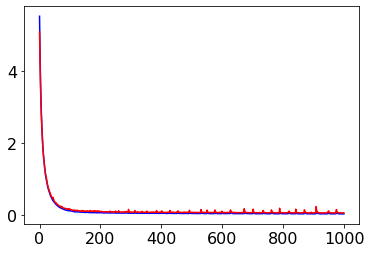

In [38]:
# Training the network:
batch_s=256
n_epochs = 1000
train(model, X_train, Y_train, batch_s, n_epochs, verbose=1, validation_split=.2)

In [39]:
# ToDo: plot the results by calling plot_forward() function. 
# Check the plot_forward() function to make sure you are giving the right inputs. 
# If you choose the right network structure, your results should be close to
# the reference velocity profile shown below

plot_forward(model,mean_Z, std_Z, mean_V, std_V)

Reference velocity profile

In [21]:
from IPython.display import Image
Image(filename='ref_vel.jpg')

In [40]:
# ToDo: calculate RMSE of validation set of velocity. Note that the network output
# is velocity after normalization. Make sure you convert these outputs to velocities.
pred = model.predict(X_train)
V_P = pred*std_V+mean_V #predicted velocities
V_true=Y_train*std_V+mean_V #true velocities
print(np.sqrt(np.mean((V_P[:16000,:]-V_true[:16000,:])**2))) #RMSE of train set (80% of data)
print(np.sqrt(np.mean((V_P[16000:,:]-V_true[16000:,:])**2))) #RMSE of validation set (20% of data)

0.05882590806674981
0.09153102480783003


In [41]:
# Calculation of RMSE of the test data. Here we use post_process function to calculate RMSE on the whole 
# river instead of small segments. You do not need to use post_process for RMSE of validation set asked above

# load test dataset: 
data_red_river = loadmat('P2_test.mat')
V_test = data_red_river['X']
Z_test = data_red_river['Y']
Uz = data_red_river['U']
Z_P = (Z_test-mean_Z)/std_Z

# predict test set velocity RMSE using your trained network:
pred = model.predict(Z_P)
V_P = pred*std_V+mean_V
velocity_prof = post_process(V_P)
velocity_prof_true = post_process(V_test)
print(np.sqrt(np.mean((velocity_prof-velocity_prof_true)**2))) #RMSE

0.09343433326371886


# Part 5


Using a 20% validation split, we train the inverse model network. 

In [14]:
# Load data and set up network input/output for inverse model:
data = loadmat('P2_train.mat')
V = data['X']
Z = data['Y']

# Normalize input and output of the network:
std_Z = np.std(Z, 0)
std_Z[std_Z==0] = 1
mean_Z = np.mean(Z,0)
std_V = np.std(V,0)
std_V[std_V==0] = 1
mean_V = np.mean(V,0)
Y_train = (Z - mean_Z)/std_Z
X_train = (V - mean_V)/std_V

In [16]:
## ToDo: perform hyperparameter selection and train the network for the inverse model

lr, reg = hyp_tuning([1e-4, 1e-3, 1e-2, 1e-1],[1e-4, 1e-3, 1e-2, 1e-1],6,[800, 700, 600, 500, 300, 100])

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 3s 198us/step - loss: 1.1917 - mse: 0.8823 - val_loss: 1.1843 - val_mse: 0.8754
Epoch 2/10
16000/16000 [==============================] - 2s 134us/step - loss: 1.0117 - mse: 0.7033 - val_loss: 1.1051 - val_mse: 0.7972
Epoch 3/10
16000/16000 [==============================] - 2s 137us/step - loss: 0.9179 - mse: 0.6105 - val_loss: 1.0158 - val_mse: 0.7089
Epoch 4/10
16000/16000 [==============================] - 2s 138us/step - loss: 0.8572 - mse: 0.5508 - val_loss: 0.9338 - val_mse: 0.6279
Epoch 5/10
16000/16000 [==============================] - 2s 138us/step - loss: 0.8127 - mse: 0.5073 - val_loss: 0.8613 - val_mse: 0.5563
Epoch 6/10
16000/16000 [==============================] - 2s 148us/step - loss: 0.7814 - mse: 0.4769 - val_loss: 0.8072 - val_mse: 0.5032
Epoch 7/10
16000/16000 [==============================] - 2s 132us/step - loss: 0.7589 - mse: 0.4553 - val_loss: 0.7793 - v

Epoch 8/10
16000/16000 [==============================] - 2s 139us/step - loss: 1.1340 - mse: 0.6839 - val_loss: 1.3682 - val_mse: 0.9528
Epoch 9/10
16000/16000 [==============================] - 2s 134us/step - loss: 1.0734 - mse: 0.6825 - val_loss: 1.4317 - val_mse: 1.0624
Epoch 10/10
16000/16000 [==============================] - 2s 128us/step - loss: 1.0287 - mse: 0.6753 - val_loss: 1.3851 - val_mse: 1.0471
Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 3s 199us/step - loss: 17.5969 - mse: 0.9261 - val_loss: 6.8114 - val_mse: 0.9667
Epoch 2/10
16000/16000 [==============================] - 2s 135us/step - loss: 3.8391 - mse: 0.8783 - val_loss: 2.3093 - val_mse: 1.0042
Epoch 3/10
16000/16000 [==============================] - 2s 147us/step - loss: 1.7029 - mse: 0.8806 - val_loss: 1.5269 - val_mse: 0.9994
Epoch 4/10
16000/16000 [==============================] - 2s 131us/step - loss: 1.2898 - mse: 0.8823 - val_loss: 1.3507 -

In [44]:
# Output the optimal hyperparameters
print(lr)
print(reg)

0.0001
0.001


In [18]:
"""
inverse model training
"""

# Set up the parameter of the network and generate the network:
input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]
n_layer = 6
n_hidden = [800, 700, 600, 500, 300, 100]
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, decay=2e-6, amsgrad=False)

optimizer_meth = adam
act_fcn = 'tanh'
model = generate_model(input_dim, output_dim, n_layer, n_hidden,
                       optimizer_meth, act_fcn, learning_rate = 1e-4, reg=1e-3)

Train on 16000 samples, validate on 4000 samples
Epoch 1/500
16000/16000 [==============================] - 4s 223us/step - loss: 3.9533 - mse: 0.8823 - val_loss: 3.8966 - val_mse: 0.8691
Epoch 2/500
16000/16000 [==============================] - 3s 161us/step - loss: 3.6817 - mse: 0.7009 - val_loss: 3.7152 - val_mse: 0.7834
Epoch 3/500
16000/16000 [==============================] - 3s 160us/step - loss: 3.4996 - mse: 0.6125 - val_loss: 3.5372 - val_mse: 0.6959
Epoch 4/500
16000/16000 [==============================] - 2s 149us/step - loss: 3.3503 - mse: 0.5507 - val_loss: 3.3925 - val_mse: 0.6357
Epoch 5/500
16000/16000 [==============================] - 2s 147us/step - loss: 3.2233 - mse: 0.5058 - val_loss: 3.2491 - val_mse: 0.5720
Epoch 6/500
16000/16000 [==============================] - 2s 130us/step - loss: 3.1121 - mse: 0.4721 - val_loss: 3.1204 - val_mse: 0.5188
Epoch 7/500
16000/16000 [==============================] - 2s 127us/step - loss: 3.0125 - mse: 0.4461 - val_loss: 3.0

16000/16000 [==============================] - 2s 153us/step - loss: 0.6576 - mse: 0.1741 - val_loss: 0.7862 - val_mse: 0.3048
Epoch 118/500
16000/16000 [==============================] - 2s 153us/step - loss: 0.6534 - mse: 0.1740 - val_loss: 0.7875 - val_mse: 0.3102
Epoch 119/500
16000/16000 [==============================] - 2s 153us/step - loss: 0.6488 - mse: 0.1735 - val_loss: 0.7801 - val_mse: 0.3069
Epoch 120/500
16000/16000 [==============================] - 2s 154us/step - loss: 0.6436 - mse: 0.1724 - val_loss: 0.7839 - val_mse: 0.3147
Epoch 121/500
16000/16000 [==============================] - 2s 155us/step - loss: 0.6406 - mse: 0.1733 - val_loss: 0.7798 - val_mse: 0.3145
Epoch 122/500
16000/16000 [==============================] - 2s 153us/step - loss: 0.6375 - mse: 0.1742 - val_loss: 0.7645 - val_mse: 0.3031
Epoch 123/500
16000/16000 [==============================] - 2s 152us/step - loss: 0.6317 - mse: 0.1723 - val_loss: 0.7699 - val_mse: 0.3124
Epoch 124/500
16000/16000 [

16000/16000 [==============================] - 3s 182us/step - loss: 0.3769 - mse: 0.1387 - val_loss: 0.5351 - val_mse: 0.2974
Epoch 234/500
16000/16000 [==============================] - 3s 163us/step - loss: 0.3780 - mse: 0.1407 - val_loss: 0.5266 - val_mse: 0.2899
Epoch 235/500
16000/16000 [==============================] - 2s 140us/step - loss: 0.3749 - mse: 0.1386 - val_loss: 0.5329 - val_mse: 0.2971
Epoch 236/500
16000/16000 [==============================] - 2s 132us/step - loss: 0.3742 - mse: 0.1388 - val_loss: 0.5392 - val_mse: 0.3044
Epoch 237/500
16000/16000 [==============================] - 2s 133us/step - loss: 0.3731 - mse: 0.1388 - val_loss: 0.5310 - val_mse: 0.2971
Epoch 238/500
16000/16000 [==============================] - 2s 137us/step - loss: 0.3698 - mse: 0.1363 - val_loss: 0.5248 - val_mse: 0.2918
Epoch 239/500
16000/16000 [==============================] - 2s 134us/step - loss: 0.3694 - mse: 0.1368 - val_loss: 0.5207 - val_mse: 0.2886
Epoch 240/500
16000/16000 [

16000/16000 [==============================] - 3s 169us/step - loss: 0.2926 - mse: 0.1223 - val_loss: 0.4494 - val_mse: 0.2793
Epoch 350/500
16000/16000 [==============================] - 3s 165us/step - loss: 0.2906 - mse: 0.1206 - val_loss: 0.4506 - val_mse: 0.2808
Epoch 351/500
16000/16000 [==============================] - 3s 164us/step - loss: 0.2922 - mse: 0.1226 - val_loss: 0.4640 - val_mse: 0.2946
Epoch 352/500
16000/16000 [==============================] - 3s 164us/step - loss: 0.2957 - mse: 0.1265 - val_loss: 0.4499 - val_mse: 0.2808
Epoch 353/500
16000/16000 [==============================] - 3s 167us/step - loss: 0.2916 - mse: 0.1227 - val_loss: 0.4464 - val_mse: 0.2776
Epoch 354/500
16000/16000 [==============================] - 3s 165us/step - loss: 0.2892 - mse: 0.1206 - val_loss: 0.4569 - val_mse: 0.2885
Epoch 355/500
16000/16000 [==============================] - 3s 170us/step - loss: 0.2884 - mse: 0.1202 - val_loss: 0.4541 - val_mse: 0.2861
Epoch 356/500
16000/16000 [

16000/16000 [==============================] - 3s 167us/step - loss: 0.2534 - mse: 0.1110 - val_loss: 0.4180 - val_mse: 0.2757
Epoch 466/500
16000/16000 [==============================] - 2s 146us/step - loss: 0.2524 - mse: 0.1101 - val_loss: 0.4153 - val_mse: 0.2732
Epoch 467/500
16000/16000 [==============================] - 2s 144us/step - loss: 0.2533 - mse: 0.1113 - val_loss: 0.4238 - val_mse: 0.2818
Epoch 468/500
16000/16000 [==============================] - 2s 146us/step - loss: 0.2519 - mse: 0.1100 - val_loss: 0.4338 - val_mse: 0.2920
Epoch 469/500
16000/16000 [==============================] - 2s 142us/step - loss: 0.2509 - mse: 0.1092 - val_loss: 0.4401 - val_mse: 0.2984
Epoch 470/500
16000/16000 [==============================] - 2s 150us/step - loss: 0.2519 - mse: 0.1104 - val_loss: 0.4359 - val_mse: 0.2944
Epoch 471/500
16000/16000 [==============================] - 2s 145us/step - loss: 0.2540 - mse: 0.1126 - val_loss: 0.4422 - val_mse: 0.3008
Epoch 472/500
16000/16000 [

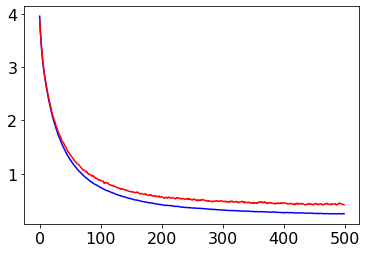

In [20]:
batch_s=256
n_epochs = 500
train(model, X_train, Y_train, batch_s, n_epochs, verbose=1, validation_split=.2)

In [21]:
# ToDo: plot the results by calling plot_inverse() function. 
# Check the plot_inverse() function to make sure you are giving the right inputs. 
# If you choose the right network structure, your results should be close to
# the reference river profile shown below

plot_inverse(model,mean_V, std_V, mean_Z, std_Z)

Reference river profile

In [75]:
from IPython.display import Image
Image(filename='ref_bathy.jpg')